## 데이터 불러오기

In [1]:
import json
import os
import shutil

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from PIL import Image
from tqdm import tqdm

import multiprocessing
from functools import partial

DATASET_ROOT = "/mnt/elice/dataset"  # 데이터 셋의 루트 디렉토리
LABELS_DIR = "labels"
IMAGE_DIR = "images"
TRAIN_DIR = "train"
TEST_DIR = "test"
# DATASET_ROOT/train/labels: 학습 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/train/images: 학습 데이터의 이미지 파일이 있는 디렉토리
# DATASET_ROOT/test/labels: 테스트 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/test/images: 테스트 데이터의 이미지 파일이 있는 디렉토리

### 학습 데이터 불러오기

In [2]:
train_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR, image)
    label_path = os.path.join(DATASET_ROOT, TRAIN_DIR, LABELS_DIR, image_id + ".txt")
    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                x = float(line.split()[1])
                y = float(line.split()[2])
                w = float(line.split()[3])
                h = float(line.split()[4])
                labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})

    train_data.append({"id": image_id, "image_path": image_path, "label_path": label_path, "labels": labels})

df_train = pd.DataFrame(train_data)
# df_train.head()

100%|██████████| 14867/14867 [00:08<00:00, 1832.65it/s]


### 테스트 데이터 불러오기

In [3]:
test_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, image)

    # 테스트 데이터는 라벨 파일이 없습니다.
    test_data.append({"id": image_id, "image_path": image_path, "label_path": "", "labels": []})

df_test = pd.DataFrame(test_data)
# df_test.head()

100%|██████████| 6369/6369 [00:00<00:00, 157948.55it/s]


## 샘플 데이터 확인하기

### 샘플 이미지

### 샘플 이미지의 라벨

라벨은 YOLO 형식으로 저장되어 있습니다.

YOLO 형식
`<object-class> <x> <y> <width> <height>`
- object-class: 물체의 클래스
- x, y: 바운딩 박스의 중심의 상대 좌표(0~1 사이 값)
- width, height: 바운딩 박스의 너비와 높이(0~1 사이 값)

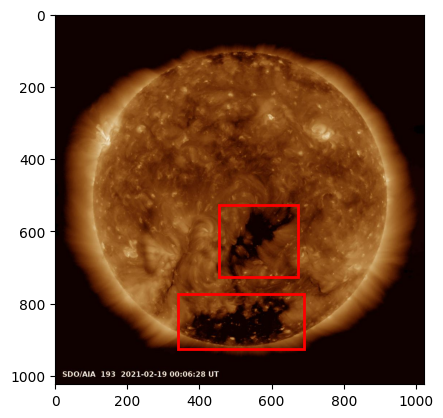

In [4]:
# 데이터프레임 df_train에서 첫 번째 샘플을 가져옴
sample = df_train.iloc[1]

# 플롯(fig)과 축(ax)을 생성
fig, ax = plt.subplots()

# 샘플의 이미지 경로에서 이미지를 열기
img = Image.open(sample["image_path"])

# 이미지 표시
ax.imshow(img)

# 샘플의 라벨 정보에 대해 바운딩 박스를 그림
for label in sample["labels"]:
    # 바운딩 박스 중심 좌표(c_x, c_y)를 이미지의 절대 좌표로 변환
    c_x = label["x"] * img.width
    c_y = label["y"] * img.height
    
    # 바운딩 박스의 너비(w)와 높이(h)를 이미지의 절대 크기로 변환
    w = label["w"] * img.width
    h = label["h"] * img.height

    # 바운딩 박스의 좌상단(left_top_x, left_top_y) 좌표 계산
    left_top_x = c_x - w / 2
    left_top_y = c_y - h / 2

    # 사각형 객체를 생성하여 바운딩 박스를 그리기
    # 좌상단 좌표 (left_top_x, left_top_y)에서 시작하여 너비 w, 높이 h의 사각형을 그림
    rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=2, edgecolor="r", facecolor="none")
    
    # 생성된 사각형(rect)을 이미지(ax)에 추가
    ax.add_patch(rect)

# 플롯을 표시
# fig.show()


## 데이터 전처리

### 데이터 분리

In [5]:
# 원본 데이터프레임 df_train에서 80%의 데이터를 무작위로 샘플링하여 학습용 데이터셋(df_train_set)을 생성
df_train_set = df_train.sample(frac=0.8, random_state=42)

# df_train_set에 포함되지 않은 나머지 20% 데이터를 검증용 데이터셋(df_valid_set)으로 설정
df_valid_set = df_train.drop(df_train_set.index)

# 학습용 데이터셋을 'train_set.csv' 파일로 저장
df_train_set.to_csv("train_set.csv", index=False)

# 검증용 데이터셋을 'valid_set.csv' 파일로 저장
df_valid_set.to_csv("valid_set.csv", index=False)

# 'train' 디렉터리의 절대 경로를 얻어서 new_train_path 변수에 저장
new_train_path = os.path.abspath("train")

# 'valid' 디렉터리의 절대 경로를 얻어서 new_valid_path 변수에 저장
new_valid_path = os.path.abspath("valid")

# 'new_train_path' 디렉터리를 생성 (이미 존재해도 에러 없이 계속 진행)
os.makedirs(new_train_path, exist_ok=True)

# 'new_train_path' 디렉터리 안에 이미지 파일을 저장할 'IMAGE_DIR' 디렉터리를 생성
os.makedirs(os.path.join(new_train_path, IMAGE_DIR), exist_ok=True)

# 'new_train_path' 디렉터리 안에 라벨 파일을 저장할 'LABELS_DIR' 디렉터리를 생성
os.makedirs(os.path.join(new_train_path, LABELS_DIR), exist_ok=True)

# 'new_valid_path' 디렉터리를 생성 (이미 존재해도 에러 없이 계속 진행)
os.makedirs(new_valid_path, exist_ok=True)

# 'new_valid_path' 디렉터리 안에 이미지 파일을 저장할 'IMAGE_DIR' 디렉터리를 생성
os.makedirs(os.path.join(new_valid_path, IMAGE_DIR), exist_ok=True)

# 'new_valid_path' 디렉터리 안에 라벨 파일을 저장할 'LABELS_DIR' 디렉터리를 생성
os.makedirs(os.path.join(new_valid_path, LABELS_DIR), exist_ok=True)


### 데이터 전처리 및 복사

이미지의 크기를 변경하고 각각 폴더에 복사합니다.

YOLO 모델은 상대 좌표를 사용하므로 이미지의 크기가 변경되어도 상대 좌표는 그대로 사용할 수 있습니다.

사용하려는 모델이 절대 좌표를 사용한다면 이미지의 크기를 변경할 때 크기에 맞게 좌표를 변경해야 합니다.

In [6]:
IMAGE_SIZE = 640

def process_row(row, is_train):
    image = Image.open(row["image_path"])
    if is_train:
        image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_train_path}/{IMAGE_DIR}/{row['id']}.jpg")
        shutil.copy(row["label_path"], f"{new_train_path}/{LABELS_DIR}/{row['id']}.txt")
    else:
        image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_valid_path}/{IMAGE_DIR}/{row['id']}.jpg")
        shutil.copy(row["label_path"], f"{new_valid_path}/{LABELS_DIR}/{row['id']}.txt")

def parallel_process(df_list, is_train):
    func = partial(process_row, is_train=is_train)
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(func, df_list), total=len(df_list)))

if __name__ == "__main__":
    # DataFrame을 딕셔너리의 리스트로 변환
    train_list = df_train_set.to_dict('records')
    valid_list = df_valid_set.to_dict('records')

    # 훈련 데이터 처리
    parallel_process(train_list, is_train=True)
    
    # 검증 데이터 처리
    parallel_process(valid_list, is_train=False)

100%|██████████| 2973/2973 [00:09<00:00, 320.10it/s]


## 모델 학습

### 모델 준비

외부 모델을 사용하는 경우 아래처럼 모델을 불러올 수 있습니다.

- 다운로드 하는 코드를 명시
- 필요한 종속성을 설치하는 코드를 명시

In [7]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)
Setup complete ✅ (16 CPUs, 192.0 GB RAM, 20.2/50.0 GB disk)


### 모델 학습

In [8]:
import os

# 현재 디렉터리의 절대 경로를 얻어와서 dataset 딕셔너리에 저장
dataset = {
    "path": os.path.abspath("."),  # 현재 작업 디렉터리의 절대 경로
    "train": "train",  # 학습 데이터가 저장된 디렉터리 이름
    "val": "valid",  # 검증 데이터가 저장된 디렉터리 이름
    "nc": 3,  # 탐지할 클래스의 수 (예: coronal_hole, sunspot, prominence)
    "names": ["coronal_hole", "sunspot", "prominence"],  # 클래스 이름 리스트
}

# YAML 파일을 저장할 경로를 지정
YAML_PATH = os.path.abspath("sun.yaml")

# 결과를 저장할 디렉터리 경로를 지정하고, 해당 디렉터리가 없으면 생성
RESULT_PATH = os.path.abspath("result30")
os.makedirs(RESULT_PATH, exist_ok=True)

# dataset 딕셔너리를 YAML 형식으로 파일로 저장
import yaml
with open(YAML_PATH, "w") as f:
    yaml.dump(dataset, f)

In [9]:
!yolo train data={YAML_PATH} pretrained=False model=yolov8l.yaml epochs=300 lr0=0.005 batch=-1 imgsz=640 augment=True workers=12 project={RESULT_PATH} name=sun cache=True device=0 amp=True dropout=0.2 patience=15


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

## 모델 평가

### 검증 데이터 예측

In [10]:
!yolo predict model={os.path.join(RESULT_PATH, 'sun/weights/best.pt')} source={os.path.join(new_valid_path, IMAGE_DIR)} conf=0.5 save=True save_txt=True save_conf=True exist_ok=True project={os.path.join(RESULT_PATH, 'valid5')}

/home/elicer/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

### 예측 결과 시각화

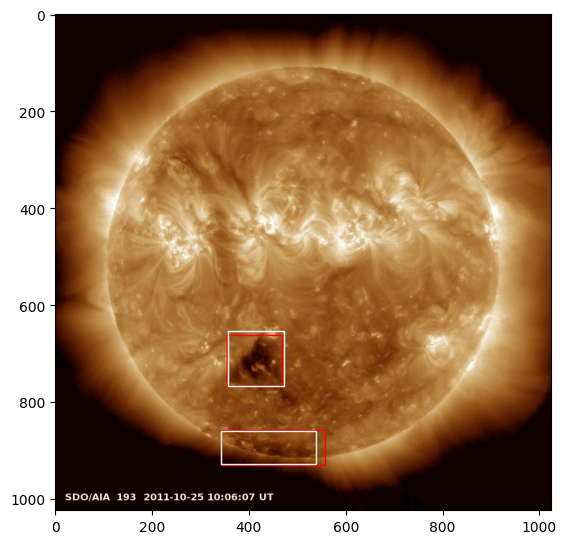

In [11]:
sample = df_valid_set.iloc[10]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])
ax.imshow(img)

# 예측 결과 시각화
predict = os.path.join(RESULT_PATH, "valid5", "predict", "labels", sample["id"] + ".txt")
if os.path.exists(predict):
    with open(predict, "r") as f:
        for line in f.readlines():
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            c_x *= img.width
            c_y *= img.height
            w *= img.width
            h *= img.height

            left_top_x = c_x - w / 2
            left_top_y = c_y - h / 2

            rect = patches.Rectangle(
                (left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

# 정답 시각화
with open(sample["label_path"], "r") as f:
    for line in f.readlines():
        class_id, c_x, c_y, w, h = map(float, line.split())
        c_x *= img.width
        c_y *= img.height
        w *= img.width
        h *= img.height

        left_top_x = c_x - w / 2
        left_top_y = c_y - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="w", facecolor="none")
        ax.add_patch(rect)
fig.set_figheight(10)
fig.show()

## 제출 파일 생성

### 테스트 데이터 예측

In [12]:
!yolo predict model={os.path.join(RESULT_PATH, 'sun/weights/best.pt')} source={os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR)} conf=0.5 save=True save_txt=True save_conf=True exist_ok=True project={os.path.join(RESULT_PATH, 'test5')}

/home/elicer/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

### 바운드 박스 읽어오기

In [13]:
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    label_path = os.path.join(RESULT_PATH, "test5", "predict", "labels", row["id"] + ".txt")

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            labels.append({"class_id": int(class_id), "conf": conf, "x": c_x, "y": c_y, "w": w, "h": h})

    df_test.at[i, "labels"] = labels
df_test

100%|██████████| 6369/6369 [00:00<00:00, 6923.78it/s]


,id,image_path,label_path,labels
0,8abb1e02042142928d5280eb2137d538,/mnt/elice/dataset/test/images/8abb1e020421429...,,"[{'class_id': 1, 'conf': 0.889283, 'x': 0.7804..."
1,e2019257735b4230b8669e8372b9b339,/mnt/elice/dataset/test/images/e2019257735b423...,,[]
2,2e31937421354646854d599dccc2c80e,/mnt/elice/dataset/test/images/2e3193742135464...,,"[{'class_id': 2, 'conf': 0.752552, 'x': 0.2070..."
3,29da3a3a93ec4c71b5415cfaac520831,/mnt/elice/dataset/test/images/29da3a3a93ec4c7...,,"[{'class_id': 1, 'conf': 0.883767, 'x': 0.3481..."
4,4d02b3570c414445b34516800e5eef75,/mnt/elice/dataset/test/images/4d02b3570c41444...,,"[{'class_id': 0, 'conf': 0.894245, 'x': 0.5137..."
...,...,...,...,...
6364,7a78ae524a5046889713af57538adbee,/mnt/elice/dataset/test/images/7a78ae524a50468...,,"[{'class_id': 2, 'conf': 0.835766, 'x': 0.2249..."
6365,c45fea81e7db468496d57044fa4f3e5a,/mnt/elice/dataset/test/images/c45fea81e7db468...,,"[{'class_id': 2, 'conf': 0.859859, 'x': 0.8301..."
6366,2715986383dc466ca338bd7167ce1fd6,/mnt/elice/dataset/test/images/2715986383dc466...,,"[{'class_id': 1, 'conf': 0.874717, 'x': 0.8347..."
6367,e94fad68d94348168d8cf3482e49f7b3,/mnt/elice/dataset/test/images/e94fad68d943481...,,"[{'class_id': 1, 'conf': 0.880566, 'x': 0.4184..."


### 생성되는 CSV 파일의 형식

CSV 파일은 각 이미지에 대한 정보를 포함하며, 다음과 같은 열(column)로 구성됩니다: 

| id        | labels                             | 
|-----------|------------------------------------| 
| image_id  | [{"class_id": ..., "x": ..., "y": ..., "w": ..., "h": ...}, ...] | 

각 행(row)은 다음과 같은 내용을 포함합니다: 
- id: 이미지의 고유 식별자 (image_id) 
- labels: 해당 이미지에 대한 라벨 정보를 포함하는 리스트 
  - 각 라벨은 다음과 같은 정보를 포함합니다: 
    - class_id: 객체의 클래스 ID 
    - x: 객체의 x 좌표 (YOLO 형식) 
    - y: 객체의 y 좌표 (YOLO 형식) 
    - w: 객체의 너비 (YOLO 형식) 
    - h: 객체의 높이 (YOLO 형식) 

예시: 
| id         | labels                                                       | 
|------------|--------------------------------------------------------------| 
| image_001  | [{"class_id": 1, "x": 0.5, "y": 0.5, "w": 0.2, "h": 0.3}] | 
| image_002  | [{"class_id": 2, "x": 0.3, "y": 0.4, "w": 0.1, "h": 0.2}, {"class_id": 1, "x": 0.7, "y": 0.8, "w": 0.15, "h": 0.25}] | 

주의: YOLO 형식의 x, y, w, h는 각각 이미지의 너비와 높이에 대한 비율로 표현되며, 
      x와 y는 객체의 중심 좌표를 기준으로 하고, w와 h는 객체의 크기를 나타냅니다.

### 제출 파일 생성

In [14]:
submission = []  # 최종 제출용 데이터를 저장할 리스트 초기화

# 테스트 데이터프레임의 각 행을 순회하면서 처리
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    image_id = row["id"]  # 현재 행의 이미지 ID를 가져옴
    labels = []  # 현재 이미지의 예측 레이블들을 저장할 리스트 초기화
    
    # 각 레이블(예측된 객체)에 대해 처리
    for label in row["labels"]:
        class_id = label["class_id"]  # 예측된 객체의 클래스 ID
        x = label["x"]  # 예측된 객체의 x 좌표
        y = label["y"]  # 예측된 객체의 y 좌표
        w = label["w"]  # 예측된 객체의 너비(width)
        h = label["h"]  # 예측된 객체의 높이(height)

        # 객체 정보를 딕셔너리 형태로 리스트에 추가
        labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})
    
    # 각 이미지 ID와 해당 이미지의 레이블 리스트를 딕셔너리로 묶어 submission 리스트에 추가
    submission.append({"id": image_id, "labels": labels})

# 최종 제출용 데이터프레임을 생성
df_submission = pd.DataFrame(submission)

# 데이터프레임을 CSV 파일로 저장 (인덱스는 제외)
df_submission.to_csv("submission.csv", index=False)


100%|██████████| 6369/6369 [00:00<00:00, 17629.15it/s]


### 제출 파일 확인

제출한 파일이 올바른 형식인지 확인합니다.

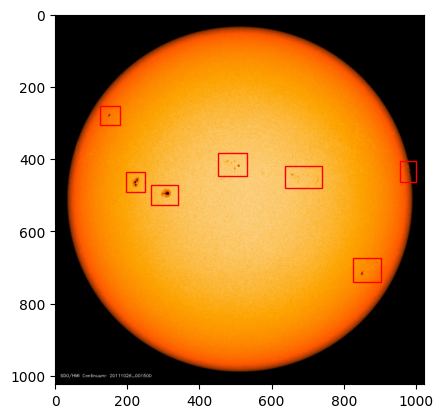

In [15]:
# 'submission.csv' 파일을 읽어와 데이터프레임으로 변환
df_submission = pd.read_csv("submission.csv")

# 11번째 행의 예측 결과를 선택
sample = df_submission.iloc[13]

# 'labels' 열의 값을 문자열로 읽어들이기 때문에 이를 평가하여 리스트로 변환
sample_labels = eval(sample["labels"])

# 예측된 레이블이 없는 경우
if len(sample_labels) == 0:
    print("예측결과: 해당 이미지에선 발견된 이벤트가 없습니다.")
else:
    # 이미지 시각화를 위한 준비
    fig, ax = plt.subplots()
    
    # 이미지 파일을 열고 이를 시각화
    img = Image.open(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, sample["id"] + ".jpg"))
    ax.imshow(img)

    # 예측된 객체의 위치와 크기를 사각형으로 표시
    for label in sample_labels:
        class_id = label["class_id"]  # 클래스 ID를 가져옴
        cx = label["x"] * img.width   # 중심 x 좌표를 원래 이미지 크기에 맞게 변환
        cy = label["y"] * img.height  # 중심 y 좌표를 원래 이미지 크기에 맞게 변환
        w = label["w"] * img.width    # 너비를 원래 이미지 크기에 맞게 변환
        h = label["h"] * img.height   # 높이를 원래 이미지 크기에 맞게 변환

        # 좌상단 좌표 계산 (YOLO 형식은 중심 좌표를 사용하기 때문에 변환이 필요)
        left_top_x = cx - (w / 2)
        left_top_y = cy - h / 2

        # 사각형 패치 생성 및 시각화에 추가
        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)  # 이미지 위에 사각형을 그려 객체의 위치를 표시


## 제출

오른쪽 위의 '제출' 버튼을 클릭하여 제출합니다.